In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [13]:
sample_images = ['../.data/images/'+img_name for img_name in os.listdir('../.data/images')]
sample_images

['../.data/images/01.jpg',
 '../.data/images/02.jpg',
 '../.data/images/03.jpg',
 '../.data/images/04.png',
 '../.data/images/05.png',
 '../.data/images/06.png',
 '../.data/images/07.png',
 '../.data/images/08.png',
 '../.data/images/09.png',
 '../.data/images/10.png',
 '../.data/images/11.png',
 '../.data/images/12.png',
 '../.data/images/13.png',
 '../.data/images/14.png',
 '../.data/images/15.png',
 '../.data/images/16.png']

In [100]:
def apply_transform(transformations=None, imgs=sample_images, title="Original"):
    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(16, 16), dpi=200, tight_layout=True)

    # If no transformer is given by default return the image
    if not transformations:
        transformations = [(lambda img, *args, **kwargs: img, [], {})]
    
    for i in range(4):
        for j in range(4):
            img = cv2.imread(imgs[i*4+j])
            transformed_img = img
            for transform, params, keyword_params in transformations:
                transformed_img = transform(transformed_img, *params, **keyword_params)
                if isinstance(transformed_img, tuple):
                    _, transformed_img = transformed_img
    
            axs[i, j].imshow(transformed_img)
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            
    fig.suptitle(title, fontsize=24)
    return fig, axs

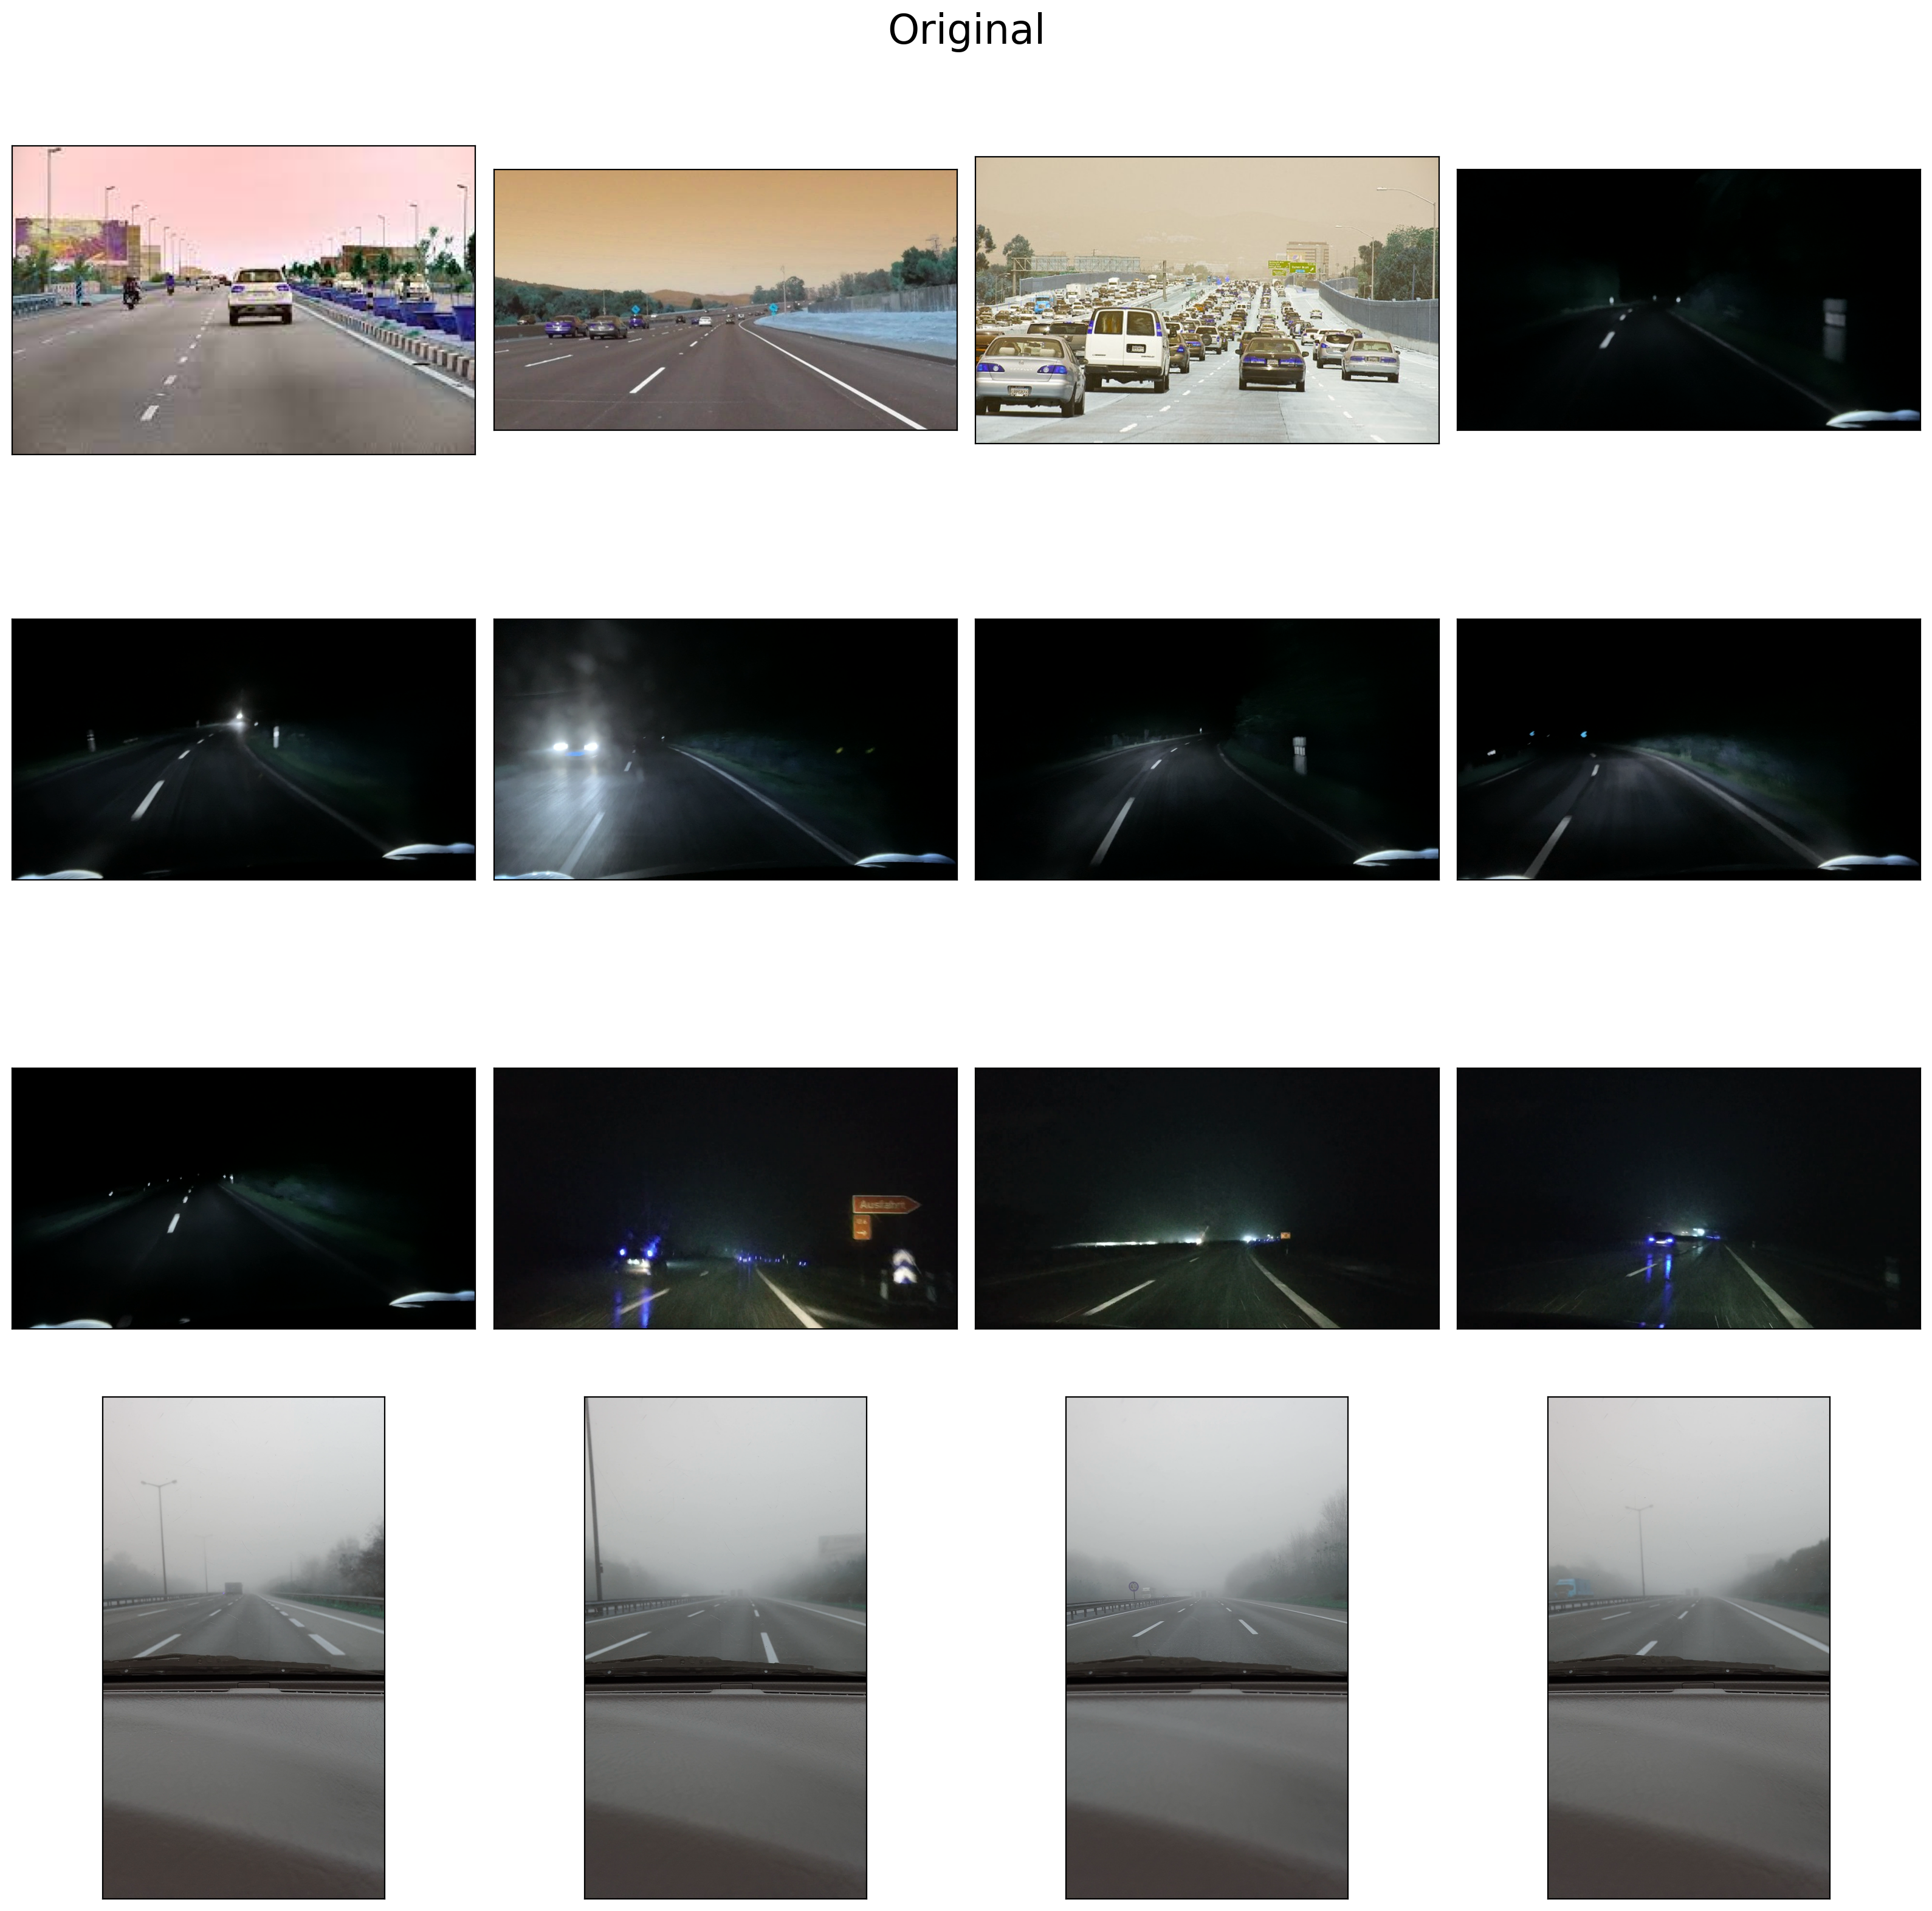

In [64]:
fig, axs = apply_transform()
plt.show()

In [95]:
def extract_white_yellow(img):

    # Define lower and upper bounds for white color in HSV
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 50, 255])
    
    # Define lower and upper bounds for yellow color in HSV
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])
    
    # Threshold the HSV image to extract white and yellow regions
    mask_white = cv2.inRange(img, lower_white, upper_white)
    mask_yellow = cv2.inRange(img, lower_yellow, upper_yellow)
    
    # Combine the white and yellow masks
    mask_combined = cv2.bitwise_or(mask_white, mask_yellow)
    
    # Apply the combined mask to the original image
    extracted_colors = cv2.bitwise_and(img, img, mask=mask_combined)
    
    return extracted_colors

In [103]:
def preprocessing_v1():
    # define the kernel 
    kernel = np.ones((3, 3), np.uint8)
    
    transformations = [
        (cv2.cvtColor, [cv2.COLOR_RGB2HSV], {}), # HSV
        (extract_white_yellow, [], {}), # W&Y
        (cv2.GaussianBlur, [(7, 7), 0], {}), # Blur
        (cv2.threshold, [200, 255, cv2.THRESH_BINARY], {}), # Binary
        (cv2.morphologyEx, [cv2.MORPH_CLOSE, kernel], {}), # Closed
        (cv2.Canny, [100, 255], {}) # Canny
    ]

    title = "HSV->W&Y->Blur->Binary->Closed->Canny"
    
    return {'transformations': transformations, 'title': title}

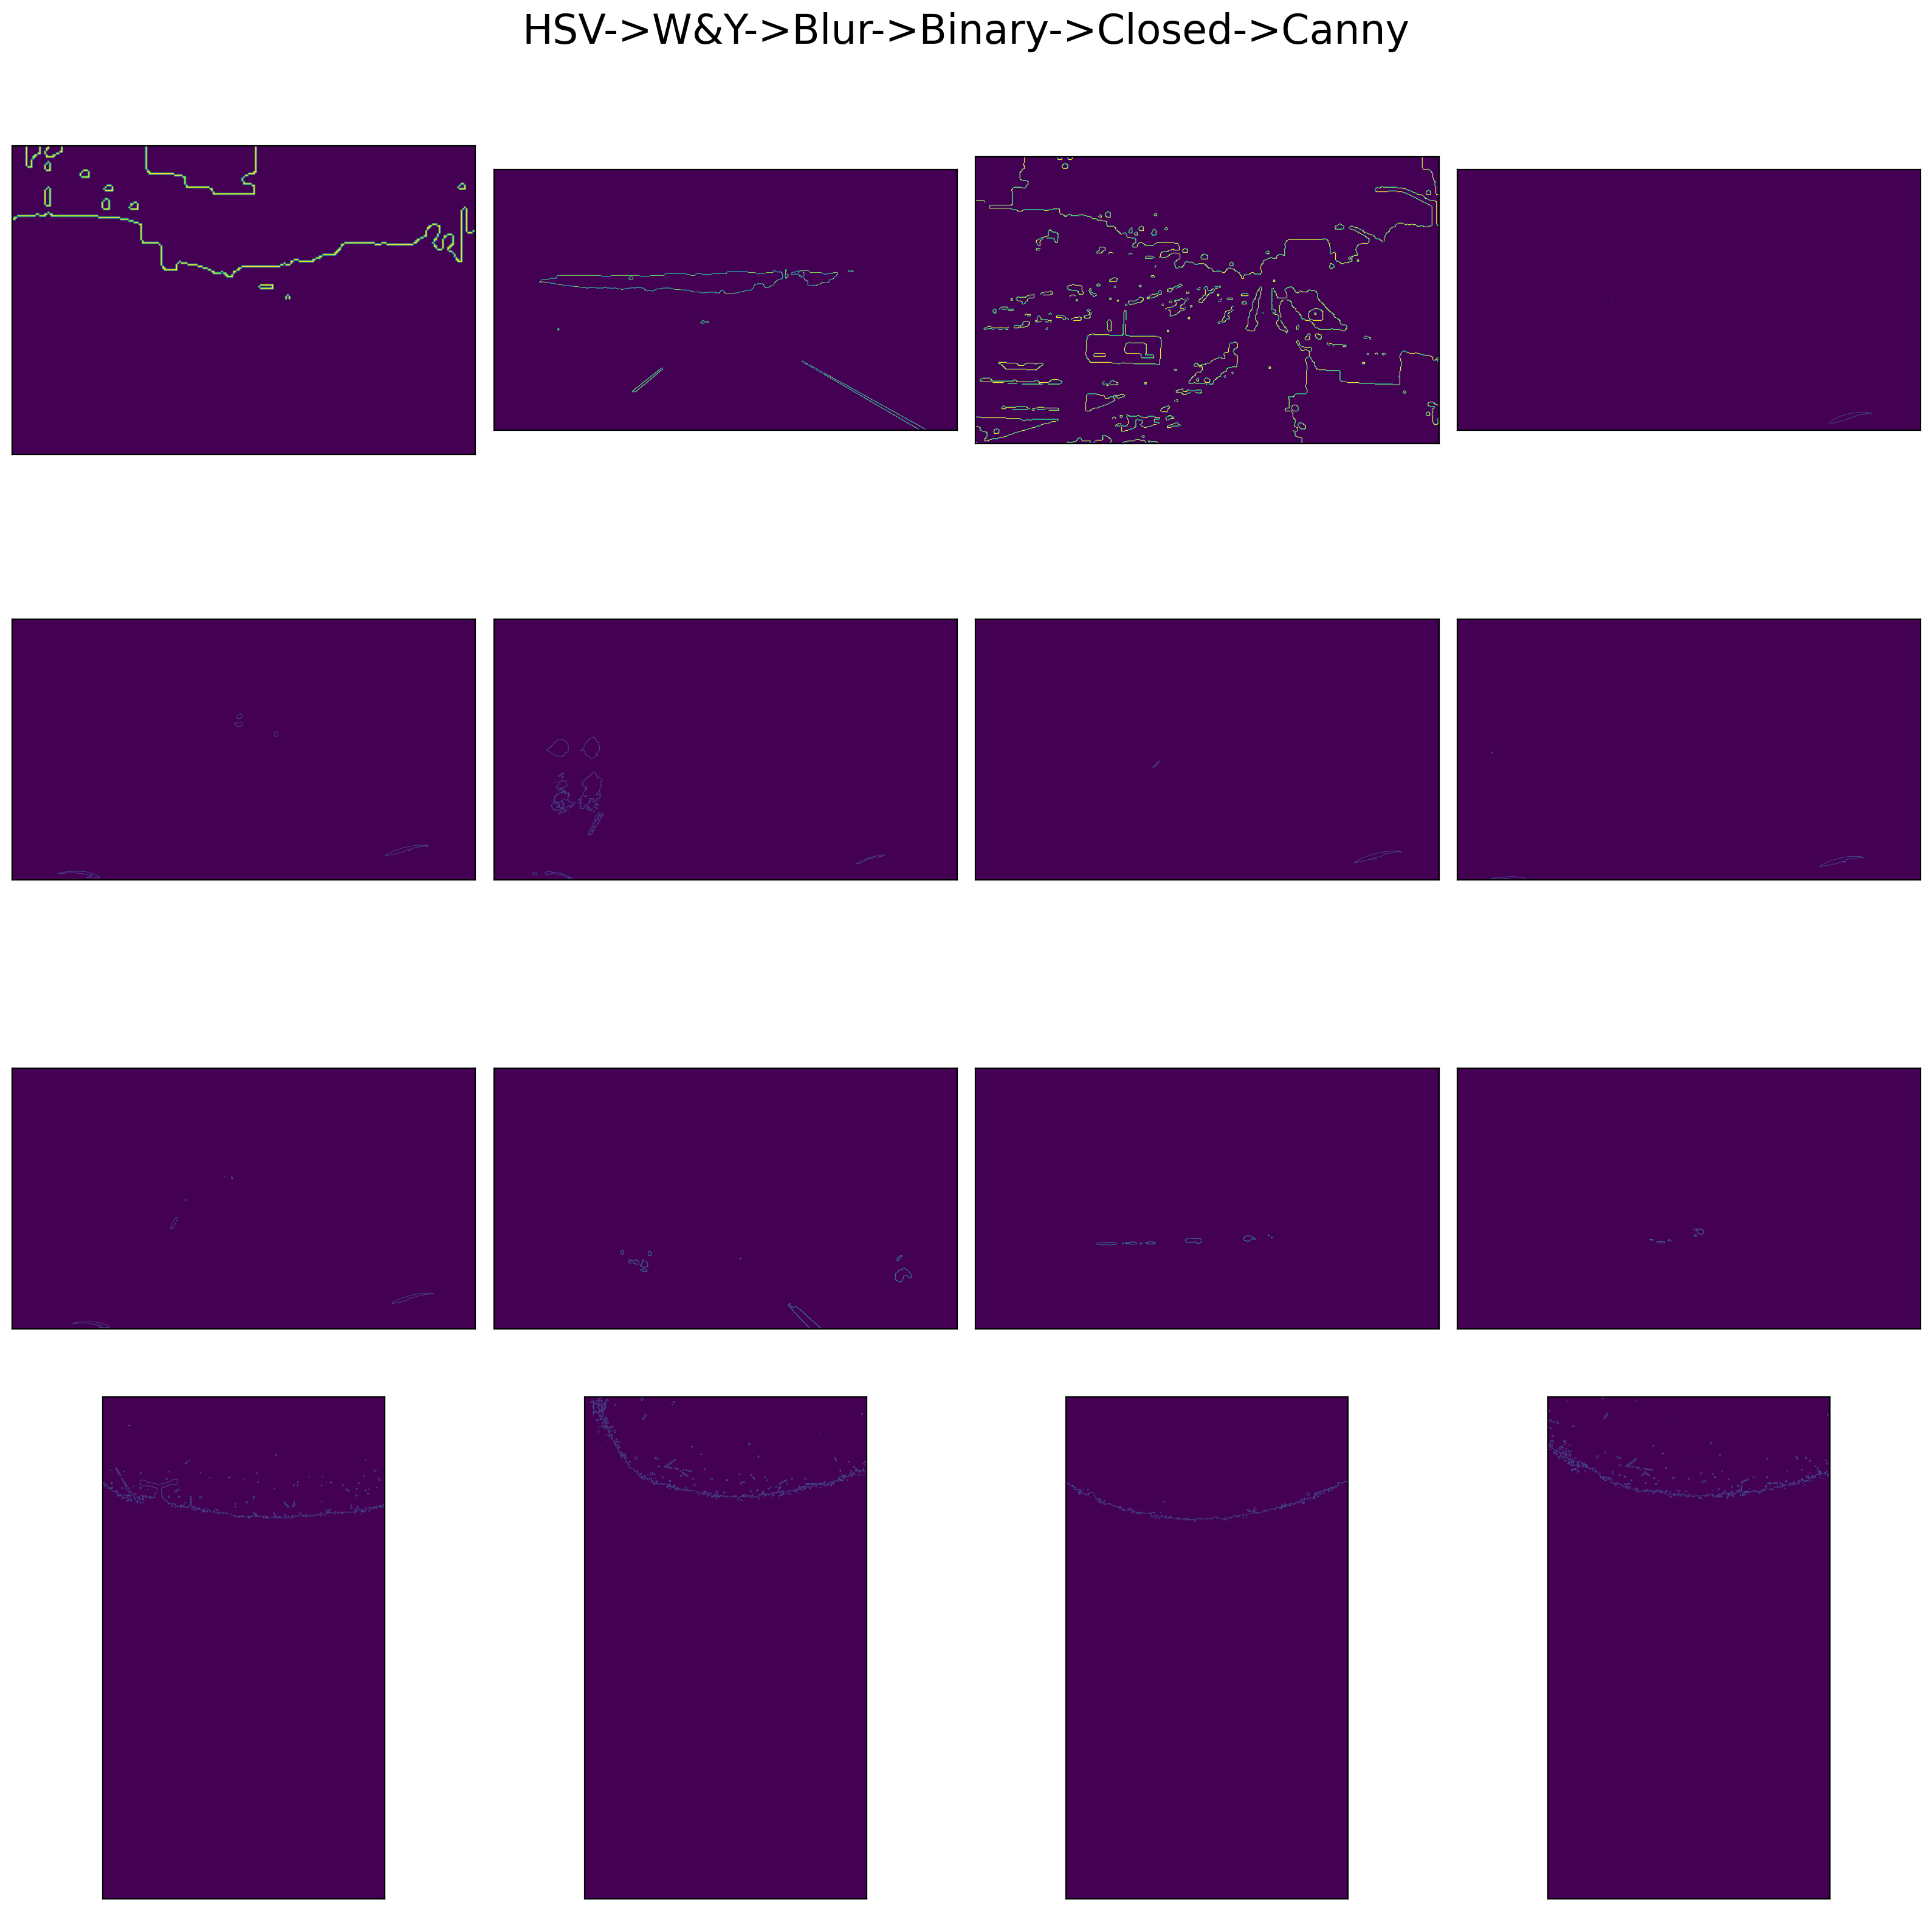

In [104]:
preprocessing_layer_info = preprocessing_v1()
fig, axs = apply_transform(preprocessing_layer_info['transformations'], title=preprocessing_layer_info['title'])
plt.show()

In [11]:
def detect_lane(img):
    # Convert it to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply gaussian blur
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply canny edge detector
    edges = cv2.Canny(blur, 50, 150)

    # Masking
    mask = np.zeros_like(edges)
    height, width = edges.shape
    triangle = np.array([
        [(0, height), (width/2, height/2), (width, height)]
    ])
    mask = cv2.fillPoly(mask, np.array(triangle, dtype=np.int32), 255)
    mask = cv2.bitwise_and(edges, mask)

    # Default detection
    detection = img
    
    # Apply Hough Transform
    lines = cv2.HoughLinesP(mask, rho=6, theta=np.pi/180, threshold=140, minLineLength=40, maxLineGap=25)

    if lines is not None:
        line_img = np.zeros_like(img)
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 5)

        detection = cv2.addWeighted(img, 0.8, line_img, 1, 0)

    return detection

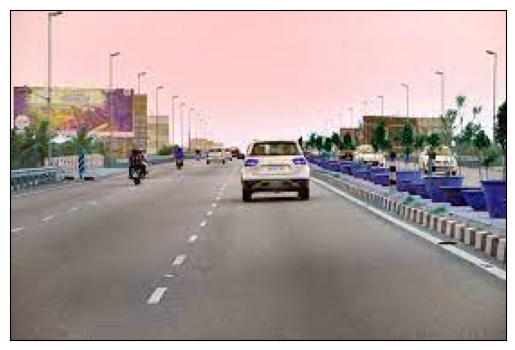

In [12]:
image_path = '../.data/images/01.jpg'
img = cv2.imread(image_path)
detection1 = detect_lane(img)
plt.imshow(detection1)
plt.xticks([])
plt.yticks([])
plt.show()

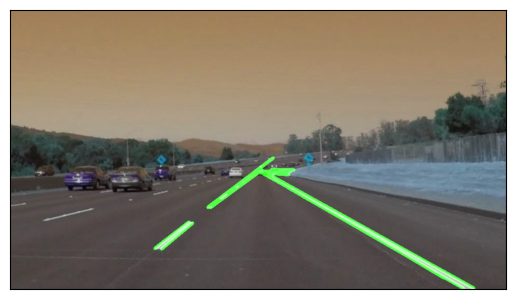

In [13]:
image_path = '../.data/images/02.jpg'
img = cv2.imread(image_path)
detection2 = detect_lane(img)
plt.imshow(detection2)
plt.xticks([])
plt.yticks([])
plt.show()

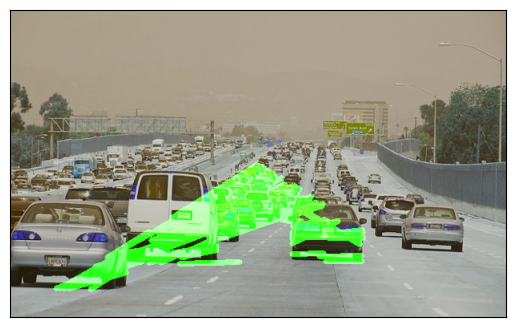

In [14]:
image_path = '../.data/images/03.jpg'
img = cv2.imread(image_path)
detection3 = detect_lane(img)
plt.imshow(detection3)
plt.xticks([])
plt.yticks([])
plt.show()

In [24]:
def video_road_lane_detector(video_path, out_name, frame_size=(640, 480)):
    # Access the video
    cap =  cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Can't open video")
        return

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('../.data/outputs/'+out_name, fourcc, 20.0, frame_size)
    
    while True:
        ret, video_frame = cap.read()
        
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break
        
        detection = detect_lane(video_frame)

        detection = cv2.resize(detection, frame_size)

        # Write the new video with detections
        out.write(detection)

        cv2.imshow("Detection", detection)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    cap.release()
    cv2.destroyAllWindows()

In [25]:
video_road_lane_detector('../.data/videos/test video 1.mp4', 'out_video_1.avi')

In [26]:
video_road_lane_detector('../.data/videos/test video 2.mp4', 'out_video_2.avi')

Can't receive frame (stream end?). Exiting ...


In [27]:
video_road_lane_detector('../.data/videos/test video 3.mp4', 'out_video_3.avi')